In [1]:
import torch
from torchvision import datasets, models, transforms
import os

In [2]:
# Constants referred by PyTorch's documentation: https://pytorch.org/docs/stable/torchvision/models.html#id3
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
data_dir = "E:/data/mvtec"

In [6]:
image_datasets = {}

In [7]:
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform)

In [8]:
image_datasets['test'] = datasets.ImageFolder(os.path.join(data_dir, 'test'), test_transform)

In [9]:
print("Training data size = %d" % len(image_datasets['train']))
print("Test data size = %d" % len(image_datasets['test']))

Training data size = 693
Test data size = 84


In [10]:
class_names = image_datasets['train'].classes
class_names

['adapter_plate_square',
 'adapter_plate_triangular',
 'box',
 'bracket_big',
 'bracket_planar',
 'bracket_screw',
 'cap',
 'car_rim',
 'clamp_big',
 'clamp_small',
 'connector_planar',
 'cylinder',
 'engine_part_bearing',
 'engine_part_cooler_round',
 'engine_part_cooler_square',
 'engine_part_cover',
 'filter',
 'fuse',
 'handle',
 'injection_pump',
 'multi_bracket',
 'punched_rail',
 'screw',
 'screw_black',
 'star',
 'tee_connector',
 'thread',
 'washer']

In [11]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 693
     Root location: E:/data/mvtec\train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 84
     Root location: E:/data/mvtec\test
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [12]:
dataloaders = {}

In [13]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=4)

In [14]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                 batch_size=8,
                                                 shuffle=True,
                                                 num_workers=4)

In [15]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x2535bc00b08>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x2535bbc8548>}

## Input images to pre-trained models should be in the format [batch_size, num_channels, height, width]

In [16]:
inputs, labels = next(iter(dataloaders['train']))

In [17]:
inputs.shape

torch.Size([8, 3, 224, 224])

In [18]:
labels

tensor([ 8, 26, 14,  7, 26, 13, 26,  0])

In [19]:
import torchvision

inp = torchvision.utils.make_grid(inputs)

In [20]:
inp.shape

torch.Size([3, 228, 1810])

In [21]:
inp.max()

tensor(2.6400)

In [22]:
import numpy as np

np.clip(inp, 0, 1).max()

tensor(1.)

In [23]:
inp.numpy().transpose((1, 2, 0)).shape

(228, 1810, 3)

In [24]:
import matplotlib.pyplot as plt

plt.ion()

In [25]:
def img_show(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean # Denormalize image to show
    inp = np.clip(inp, 0, 1) # To be shown, pixels must be between 0 and 1
    plt.figure(figsize=(16, 4))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
        

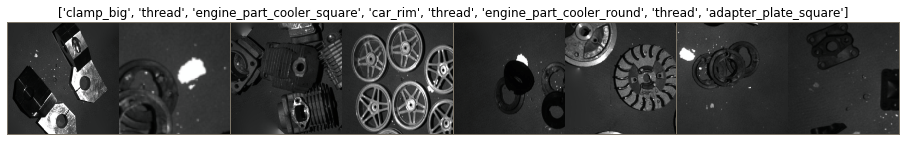

In [26]:
img_show(inp, title=[class_names[x] for x in labels])

In [27]:
model = models.resnet18(pretrained=True)

In [28]:
# Add a linear layer to pre-trained model in order to replace the current final linear layer in the original model
# In order to do that we need to get the number of features to pass into our last layer
num_ftrs = model.fc.in_features
num_ftrs

512

In [29]:
import torch.nn as nn

In [30]:
model.fc = nn.Linear(num_ftrs, 28)

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
import torch.optim as optim

optimizer = optim.SGD(model.parameters(),
                     lr=0.001,
                     momentum=0.9) # Momentum is used to accelerate model convergence


In [33]:
from torch.optim import lr_scheduler

# Learning rate scheduler decreases the learning rate as we get closer to convergence, by 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size=7,
                                      gamma=0.1)


In [34]:
def calculate_accuracy(phase, running_loss, running_corrects):
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    return (epoch_loss, epoch_acc)


In [35]:
def phase_train(model, criterion, optimizer, scheduler):
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step() # Update model parameters
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    calculate_accuracy('train', running_loss, running_corrects)


In [36]:
import copy

In [37]:
best_acc = 0.0

In [38]:
def phase_test(model, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    global best_acc
    for inputs, labels in dataloaders['test']:
        optimizer.zero_grad()
        with torch.no_grad(): # Do not calculate gradients in test phase
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    # Store the weights of that model which has the best accuracy so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    return best_model_wts


In [39]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
    print('Best test accuracy: {:4f}'.format(best_acc))
    # At the end of training load the model with best accuracy in test
    model.load_state_dict(best_model_wts)
    return model


In [40]:
model = build_model(model,
                   criterion,
                   optimizer,
                   exp_lr_scheduler,
                   num_epochs=1)


Epoch 1/1
----------


C:\Anaconda3\envs\iotedgeenv\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.5875 Acc: 0.3203
test Loss: 1.3927 Acc: 0.7143

Best test accuracy: 0.714286


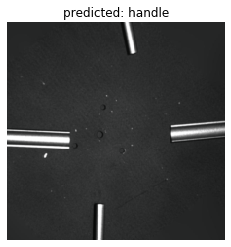

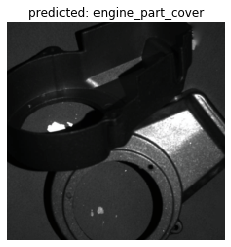

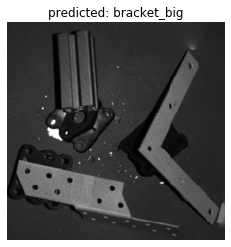

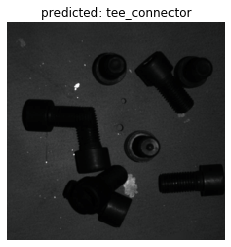

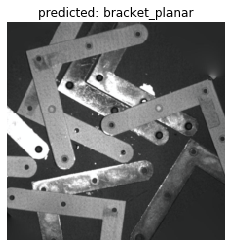

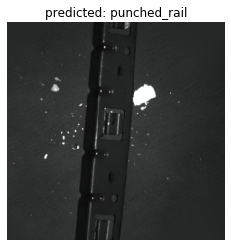

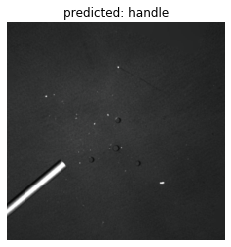

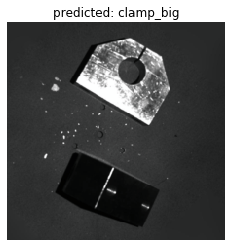

In [41]:
with torch.no_grad():
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted: ' + class_names[preds[j]])
        

In [42]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [43]:
frozen_model = models.resnet18(pretrained=True)

In [44]:
# This time reloads the model freezing all pre-trained layers
for param in frozen_model.parameters():
    param.requires_grad = False

In [45]:
# Add new linear layer to the bottom of the model. This is the only layer that will be trained
frozen_model.fc = nn.Linear(num_ftrs, 28)

In [46]:
optimizer = optim.SGD(frozen_model.fc.parameters(),
                     lr=0.001,
                     momentum=0.9)


In [47]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size=7,
                                      gamma=0.1)


In [48]:
criterion = nn.CrossEntropyLoss()

In [49]:
best_acc = 0.0

In [50]:
frozen_model = build_model(frozen_model,
                          criterion,
                          optimizer,
                          exp_lr_scheduler,
                          num_epochs=5)


Epoch 1/5
----------
train Loss: 3.0766 Acc: 0.1573
test Loss: 2.5439 Acc: 0.2976

Epoch 2/5
----------
train Loss: 2.2462 Acc: 0.4343
test Loss: 1.8211 Acc: 0.5714

Epoch 3/5
----------
train Loss: 1.8378 Acc: 0.5657
test Loss: 1.3490 Acc: 0.7143

Epoch 4/5
----------
train Loss: 1.5577 Acc: 0.6306
test Loss: 1.0794 Acc: 0.7976

Epoch 5/5
----------
train Loss: 1.3562 Acc: 0.7027
test Loss: 0.9846 Acc: 0.7857

Best test accuracy: 0.797619


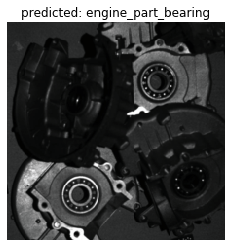

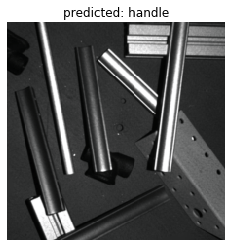

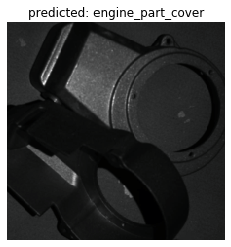

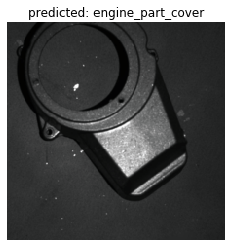

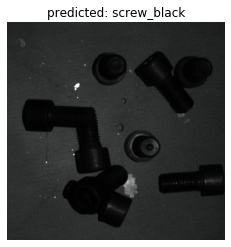

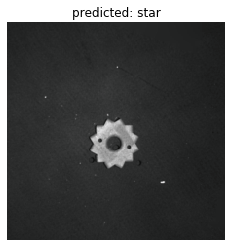

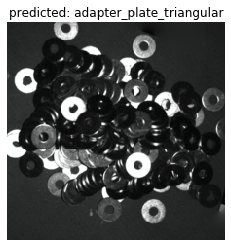

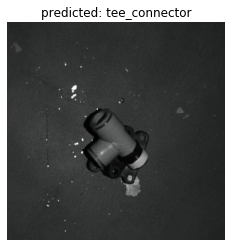

In [51]:
with torch.no_grad():
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    outputs = frozen_model(inputs)
    _, preds = torch.max(outputs, 1)
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted: ' + class_names[preds[j]])
